In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random


In [58]:

cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
matplotlib.colormaps.register(cmap)

random_seed = 42


def set_random_seed(random_seed):
    """
    Function to set up random seed to be fixed, so we have consistent results
    """
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)


set_random_seed(random_seed)

# exploring the environment of the host, if the use of graphics card is available.
print("CUDA Available: ", torch.cuda.is_available())
print("cuDNN Enabled: ", torch.backends.cudnn.enabled)
print("cuDNN Version: ", torch.backends.cudnn.version())

# set up to use deterministic algorithms, so we have consistent results
torch.backends.cudnn.deterministic = True

ValueError: A colormap named "red_blue_classes" is already registered.

# Data

A credit score is a numerical representation of a person's creditworthiness. It is based on an individual's credit history, which includes factors such as how much debt they have, their payment history, the length of their credit history, the types of credit they have used, and recent credit inquiries.

In [2]:
import pandas as pd

df_data = pd.read_csv('data.csv')
df_data.head()

,Monthly Salary (CZK),Credit Score,Loan Approved
0,17322.625930,320.339409,0
1,17696.524569,256.730055,0
2,17798.603219,301.174837,0
3,28957.762157,422.280940,1
4,22401.138392,602.256374,1


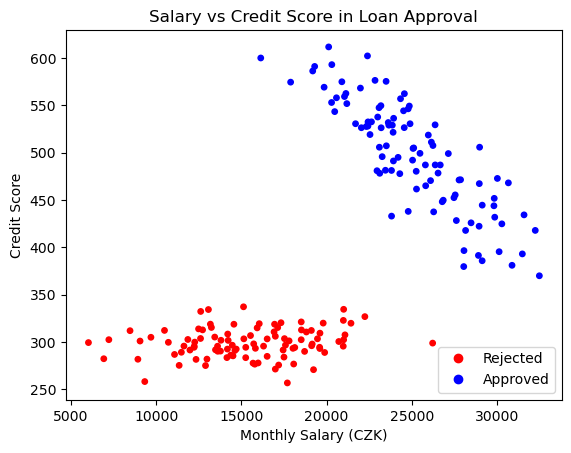

In [60]:
def plot_data(x, y, labels, ax):
    scatter = ax.scatter(x, y, c=labels, cmap='bwr_r',
                         s=15)
    ax.set_xlabel('Monthly Salary (CZK)')
    ax.set_ylabel('Credit Score')
    ax.set_title('Salary vs Credit Score in Loan Approval')
    legend_elements, _ = scatter.legend_elements()
    ax.legend(handles=legend_elements, labels=['Rejected', 'Approved'], loc='lower right')
    
fig, ax = plt.subplots()
plot_data(df_data['Monthly Salary (CZK)'], df_data['Credit Score'],df_data['Loan Approved'], ax)

In [52]:
X_train = df_data.drop(['Loan Approved'], axis=1)
y_train = df_data['Loan Approved']

In [53]:
X_train.head()

,Monthly Salary (CZK),Credit Score
0,17322.625930,320.339409
1,17696.524569,256.730055
2,17798.603219,301.174837
3,28957.762157,422.280940
4,22401.138392,602.256374


In [54]:
y_train.head()

0    0
1    0
2    0
3    1
4    1
Name: Loan Approved, dtype: int64

# Model

- ukazat rozhodovaci hranici - nejprve na logisticke regresi - neco velmi jednoducheho
- pote na neuronove siti
- je dobre porovnat log regresi a sit, protoze log regrese je odolnejsi k data poisoningu
- pote ukazat ten web playground

In [55]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train.to_numpy(), y_train.to_numpy())

LogisticRegression()

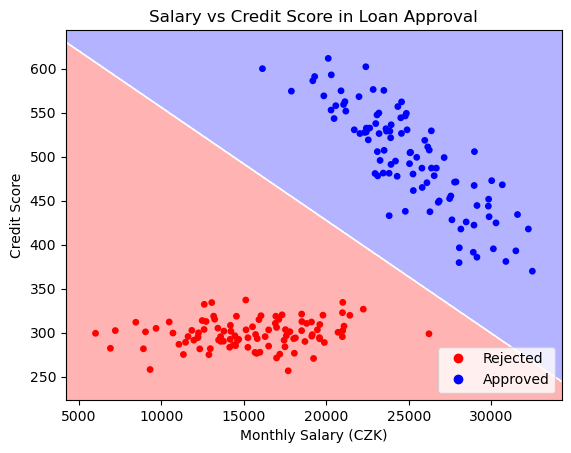

In [61]:
def plot_decision_boundary(X, y, model):
    fig, ax = plt.subplots()

    margin_factor = 0.3
    x_min, x_max = X[:, 0].min() - margin_factor * X[:, 0].std(), X[:, 0].max() + margin_factor * X[:, 0].std()
    y_min, y_max = X[:, 1].min() - margin_factor * X[:, 1].std(), X[:, 1].max() + margin_factor * X[:, 1].std()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10), np.arange(y_min, y_max, 1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    ax.contour(xx, yy, Z, [0.5], linewidths=1.0, colors="white")
    plot_data(X[:, 0], X[:, 1], y, ax)


plot_decision_boundary(X_train.to_numpy(), y_train.to_numpy(), model)

In [23]:
import torch.nn.functional as F

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create a DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x


# Initialize the model, loss function, and optimizer
nn_model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

# Train the model
for epoch in range(200):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [24]:
def plot_nn_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 1))
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = (Z.detach().numpy() > 0.5).astype(int)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap='bwr')
    plt.xlabel('Word Frequency of "Free"')
    plt.ylabel('Email Length')
    plt.title('Neural Network Decision Boundary')
    plt.show()


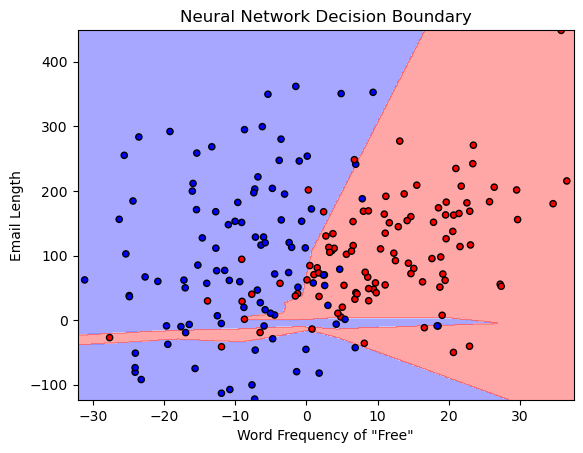

In [25]:
plot_nn_decision_boundary(X, y, nn_model)

# Data Poisoning
- pridata data tak, aby vznikla bublina pro hackera, o ktere vi jenom on a muze tak obejit system

In [13]:
# Poison the data
X_poison = X.copy()
y_poison = y.copy()
X_poison[:10, 0] = X_poison[:10, 0] + 20  # Increase word frequency of "free"
y_poison[:10] = 0  # Flip the labels to "Not Spam"

# Retrain the logistic regression model with poisoned data
model_poisoned = LogisticRegression()
model_poisoned.fit(X_poison, y_poison)

LogisticRegression()

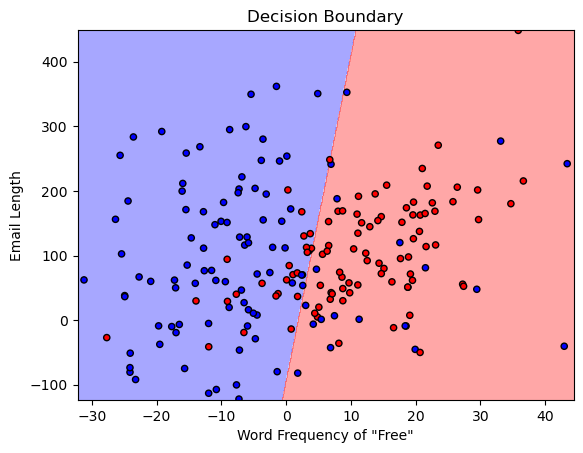

In [14]:
# Logistic Regression Decision Boundary
plot_decision_boundary(X_poison, y_poison, model_poisoned)

In [26]:
# Convert poisoned data to PyTorch tensors
X_poison_tensor = torch.tensor(X_poison, dtype=torch.float32)
y_poison_tensor = torch.tensor(y_poison, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for poisoned data
poisoned_dataset = TensorDataset(X_poison_tensor, y_poison_tensor)
poisoned_dataloader = DataLoader(poisoned_dataset, batch_size=16, shuffle=True)

# Retrain the neural network with poisoned data
nn_model_poisoned = SimpleNN()
optimizer_poisoned = optim.Adam(nn_model_poisoned.parameters(), lr=0.01)

# Train the poisoned model
for epoch in range(200):
    for batch_X, batch_y in poisoned_dataloader:
        optimizer_poisoned.zero_grad()
        outputs = nn_model_poisoned(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_poisoned.step()

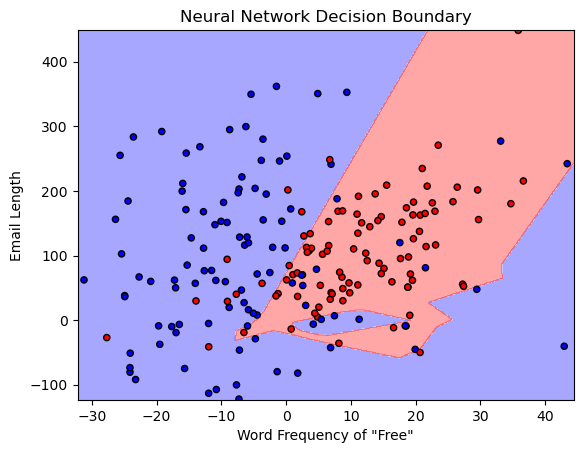

In [27]:
plot_nn_decision_boundary(X_poison, y_poison, nn_model_poisoned)

# Adversarial training

- jako typ expertu zkusime tuto situaci nejak zachranit
- zkusime se podivat na outliery
- zkusime odstranit regiony kde je mozny unik pomoci posileni dat o male perturbace

In [28]:
import torch


def generate_adversarial_examples(model, X, y, epsilon=0.1):
    # Set model to evaluation mode
    model.eval()

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Collect the gradients of the input
    data_grad = X_tensor.grad.data

    # Create adversarial examples by adding a small perturbation
    X_adversarial = X_tensor + epsilon * data_grad.sign()

    # Ensure the adversarial examples are still in the same range as the original data
    X_adversarial = torch.clamp(X_adversarial, min=X_tensor.min(), max=X_tensor.max())

    return X_adversarial.detach().numpy()


# Generate adversarial examples
X_adversarial = generate_adversarial_examples(nn_model, X, y)

In [37]:
X

array([[-8.72928982e+00,  1.30419976e+00],
       [ 1.31293463e+01,  2.77053357e+02],
       [ 2.34042818e+01,  2.42099601e+02],
       [ 2.29454774e+01, -4.04380188e+01],
       [ 9.44105156e+00,  4.77240904e+01],
       [-1.19596886e+00,  5.08913136e+01],
       [ 1.51084697e+00,  8.10076773e+01],
       [-7.45440696e-02, -4.52842565e+01],
       [-1.25396925e+01,  6.76923618e+00],
       [-2.43924147e+00,  1.19979806e+02],
       [-1.92089280e+01,  2.91894990e+02],
       [ 4.88062692e+00,  3.50578584e+02],
       [ 2.25751204e+01,  1.81515089e+02],
       [-3.12190908e+01,  6.22201446e+01],
       [ 1.87768113e+01,  5.10959839e+01],
       [ 4.67855418e+00,  7.87192799e+01],
       [ 4.84048087e+00,  4.84384166e+00],
       [-5.42355184e+00,  3.49536942e+02],
       [ 1.04235818e+01,  1.10204918e+02],
       [ 1.63367133e+01,  5.92193278e+01],
       [ 1.85756778e+01,  1.73826470e+02],
       [-2.41167954e+01, -8.06209136e+01],
       [ 8.74819183e+00,  4.88156642e+01],
       [ 9.

In [29]:
X_adversarial

array([[-8.82929039e+00,  1.40419984e+00],
       [ 1.30293455e+01,  2.77153351e+02],
       [ 2.33042812e+01,  2.42199600e+02],
       [ 2.28454762e+01, -4.05380173e+01],
       [ 9.34105110e+00,  4.78240891e+01],
       [-1.09596884e+00,  5.07913170e+01],
       [ 1.41084695e+00,  8.11076736e+01],
       [-1.74544066e-01, -4.51842575e+01],
       [-1.24396925e+01,  6.66923618e+00],
       [-2.33924150e+00,  1.19879807e+02],
       [-1.91089268e+01,  2.91794983e+02],
       [ 4.98062658e+00,  3.50478577e+02],
       [ 2.24751205e+01,  1.81615097e+02],
       [-3.11190910e+01,  6.23201447e+01],
       [ 1.86768112e+01,  5.11959839e+01],
       [ 4.77855396e+00,  7.86192780e+01],
       [ 4.74048090e+00,  4.74384165e+00],
       [-5.32355213e+00,  3.49436951e+02],
       [ 1.03235817e+01,  1.10304916e+02],
       [ 1.62367134e+01,  5.93193245e+01],
       [ 1.84756775e+01,  1.73926483e+02],
       [-2.42167950e+01, -8.05209122e+01],
       [ 8.64819145e+00,  4.89156609e+01],
       [ 1.

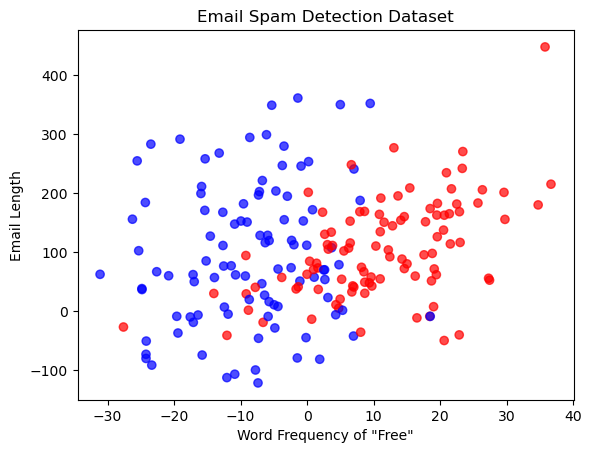

In [31]:
# Plot the dataset
plt.scatter(X_adversarial[:, 0], X_adversarial[:, 1], c=y, cmap='bwr', alpha=0.7)
plt.xlabel('Word Frequency of "Free"')
plt.ylabel('Email Length')
plt.title('Email Spam Detection Dataset')
plt.show()

In [32]:
# Combine original and adversarial data
X_combined = np.vstack((X, X_adversarial))
y_combined = np.hstack((y, y))

# Convert combined data to PyTorch tensors
X_combined_tensor = torch.tensor(X_combined, dtype=torch.float32)
y_combined_tensor = torch.tensor(y_combined, dtype=torch.float32).view(-1, 1)

# Create a DataLoader for combined data
combined_dataset = TensorDataset(X_combined_tensor, y_combined_tensor)
combined_dataloader = DataLoader(combined_dataset, batch_size=16, shuffle=True)

# Define the adversarially trained neural network model
nn_model_adv = SimpleNN()
optimizer_adv = optim.Adam(nn_model_adv.parameters(), lr=0.01)

# Train the adversarially trained model
for epoch in range(200):
    for batch_X, batch_y in combined_dataloader:
        optimizer_adv.zero_grad()
        outputs = nn_model_adv(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_adv.step()

In [36]:
X_combined

array([[-8.72928982e+00,  1.30419976e+00],
       [ 1.31293463e+01,  2.77053357e+02],
       [ 2.34042818e+01,  2.42099601e+02],
       [ 2.29454774e+01, -4.04380188e+01],
       [ 9.44105156e+00,  4.77240904e+01],
       [-1.19596886e+00,  5.08913136e+01],
       [ 1.51084697e+00,  8.10076773e+01],
       [-7.45440696e-02, -4.52842565e+01],
       [-1.25396925e+01,  6.76923618e+00],
       [-2.43924147e+00,  1.19979806e+02],
       [-1.92089280e+01,  2.91894990e+02],
       [ 4.88062692e+00,  3.50578584e+02],
       [ 2.25751204e+01,  1.81515089e+02],
       [-3.12190908e+01,  6.22201446e+01],
       [ 1.87768113e+01,  5.10959839e+01],
       [ 4.67855418e+00,  7.87192799e+01],
       [ 4.84048087e+00,  4.84384166e+00],
       [-5.42355184e+00,  3.49536942e+02],
       [ 1.04235818e+01,  1.10204918e+02],
       [ 1.63367133e+01,  5.92193278e+01],
       [ 1.85756778e+01,  1.73826470e+02],
       [-2.41167954e+01, -8.06209136e+01],
       [ 8.74819183e+00,  4.88156642e+01],
       [ 9.

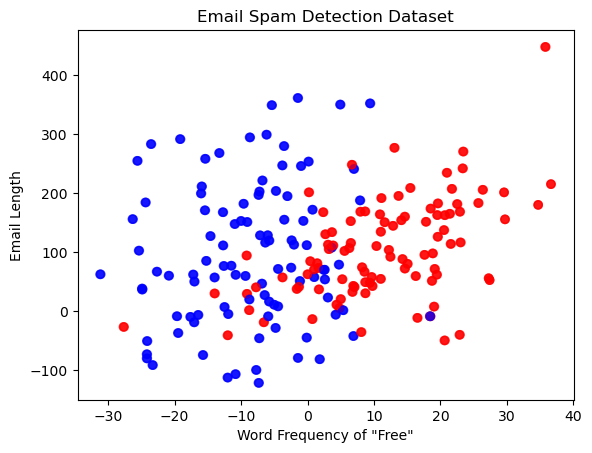

In [34]:
# Plot the dataset
plt.scatter(X_combined[:, 0], X_combined[:, 1], c=y_combined, cmap='bwr', alpha=0.7)
plt.xlabel('Word Frequency of "Free"')
plt.ylabel('Email Length')
plt.title('Email Spam Detection Dataset')
plt.show()

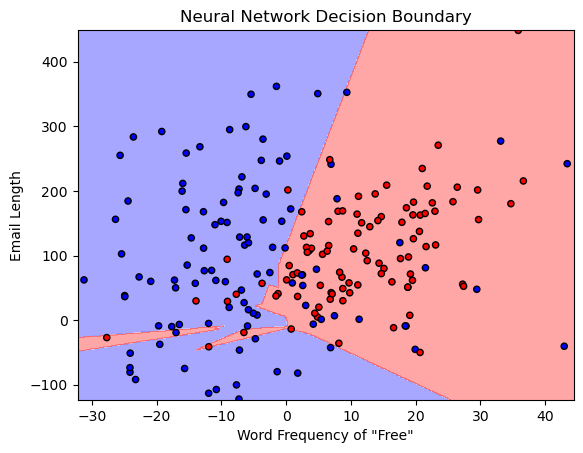

In [33]:
# Neural Network Decision Boundary After Adversarial Training
plot_nn_decision_boundary(X_poison, y_poison, nn_model_adv)
